In [75]:
# General imports
import math
import matplotlib
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from easypreprocessing import EasyPreProcessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Hyperopt imports
from hyperopt import hp
from hyperopt import tpe
from hpsklearn import any_regressor
from hpsklearn import HyperoptEstimator
from sklearn.metrics import accuracy_score
from hpsklearn import any_classifier, any_preprocessing

## Custom Data Pre-Processing

In [76]:
# loading and processing data with EasyPreProcessing 
prep = EasyPreProcessing('data/raw_train_data.csv')


**Initialization Parameters**

1.  output            - Set output variable/dependent variable
2.  dates.features    - Set datetime field names (optional)

For example:
1.  output = 'column_name'
2.  dates.features = ['date_field_1','date_field_2']
        

In [77]:
prep.info



**General Template**
<code>
from easypreprocessing import EasyPreProcessing
prep = EasyPreProcessing('filename_here.csv')
prep.df
prep.output = 'output_variable_here'
prep.remove_blank()
prep.missing_values
prep.categorical.impute()
prep.numerical.impute()
prep.categorical.encode()
prep.correlation()
prep.standardize()
X_train, X_test, y_train, y_test = prep.split()
</code>


**Categorical Preprocessing**
<table>
<tr>
<td>categorical.fields</td><td>Display all categorical field names</td>
</tr>
<tr>
<td>categorical.unique</td><td>Display unique/distinct categorical values</td>
</tr>
<tr>
<td>categorical.impute()</td><td>Handle categorical missing values. Parameters {'mean', 'medium', 'mode'}</td>
</tr>
<tr>
<td>categorical.encode()</td><td>Encode categorical features. Parameters {'le': LabelEncoding, 'ohe': OneHotEncoding}</td>
</tr>
</table>

**Numerical Preprocessing**
<table>
<tr>
<td>numerical.fields</td><td>Display all numerical field names</td>
</tr>
<tr>
<td>numerical.impute()</td><td>Handle numerical missing values. Parameters {'mean', 'medium', 'mode'}</td>
</tr>
</table>

**Date Preprocessing**
<table>
<tr>
<td>dates.features</td><td>Define list of all datetime feature names</td>
</tr>
<tr>
<td>dates.split_datetime()</td><td>Split all datetime features into discrete fields (Year, Month, Day, Hour, Minute)</td>
</tr>
</table>

**General Preprocessing**
<table>
<tr>
<td>missing_values</td><td>Display missing value report</td>
</tr>
<tr>
<td>remove_blank()</td><td>Remove empty/blank columns</td>
</tr>
<tr>
<td>correlation()</td><td>Display correlation heatmap</td>
</tr>
<tr>
<td>standardize()</td><td>Standardize entire dataset except dependent variable</td>
</tr>
<tr>
<td>encode_output()</td><td>Encode dependent feature/output variable</td>
</tr>
<tr>
<td>over_sample()</td><td>Oversample dataset. Parameters {'smote': SMOTE, 'ros': RandomOverSample}</td>
</tr>
<tr>
<td>clustering.apply()</td><td>Cluster dataset using elbow plot</td>
</tr>
</table>
        

## Handling Null Values

In [78]:
prep.categorical.fields

['week']

In [79]:
prep.numerical.fields

['record_ID',
 'store_id',
 'sku_id',
 'total_price',
 'base_price',
 'is_featured_sku',
 'is_display_sku',
 'units_sold']

In [80]:
prep.missing_values

record_ID          0
week               0
store_id           0
sku_id             0
total_price        1
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64

In [81]:
prep.numerical.impute()

Numerical features imputated successfully.


In [82]:
prep.df.shape

(150150, 9)

In [83]:
prep.df

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1.0,17/01/11,8091.0,216418.0,99.0375,111.8625,0.0,0.0,20.0
1,2.0,17/01/11,8091.0,216419.0,99.0375,99.0375,0.0,0.0,28.0
2,3.0,17/01/11,8091.0,216425.0,133.9500,133.9500,0.0,0.0,19.0
3,4.0,17/01/11,8091.0,216233.0,133.9500,133.9500,0.0,0.0,44.0
4,5.0,17/01/11,8091.0,217390.0,141.0750,141.0750,0.0,0.0,52.0
...,...,...,...,...,...,...,...,...,...
150145,212638.0,09/07/13,9984.0,223245.0,235.8375,235.8375,0.0,0.0,38.0
150146,212639.0,09/07/13,9984.0,223153.0,235.8375,235.8375,0.0,0.0,30.0
150147,212642.0,09/07/13,9984.0,245338.0,357.6750,483.7875,1.0,1.0,31.0
150148,212643.0,09/07/13,9984.0,547934.0,141.7875,191.6625,0.0,1.0,12.0


Create a new column 'key' for unique identification. This is done in order to handle the duplicate data in 'week' column.

In [84]:
prep.dataset['key'] = prep.df['week'].astype(str) + '_' + prep.df['store_id'].astype(str) 

Removing columns that are not helpful for time series predictions.

In [85]:
prep.dataset = prep.df.drop(['record_ID', 'week', 'store_id', 'sku_id', 'total_price', 'base_price', 'is_featured_sku', 'is_display_sku'], axis=1)

In [86]:
prep.df

,units_sold,key
0,20.0,17/01/11_8091.0
1,28.0,17/01/11_8091.0
2,19.0,17/01/11_8091.0
3,44.0,17/01/11_8091.0
4,52.0,17/01/11_8091.0
...,...,...
150145,38.0,09/07/13_9984.0
150146,30.0,09/07/13_9984.0
150147,31.0,09/07/13_9984.0
150148,12.0,09/07/13_9984.0


Summing units_sold group by key.

In [87]:
prep.dataset = prep.df.groupby('key').sum()

In [88]:
prep.df

,units_sold
key,
01/01/13_8023.0,2025.0
01/01/13_8058.0,682.0
01/01/13_8063.0,535.0
01/01/13_8091.0,210.0
01/01/13_8094.0,782.0
...,...
31/10/11_9890.0,531.0
31/10/11_9909.0,551.0
31/10/11_9954.0,431.0


<Axes: xlabel='key'>

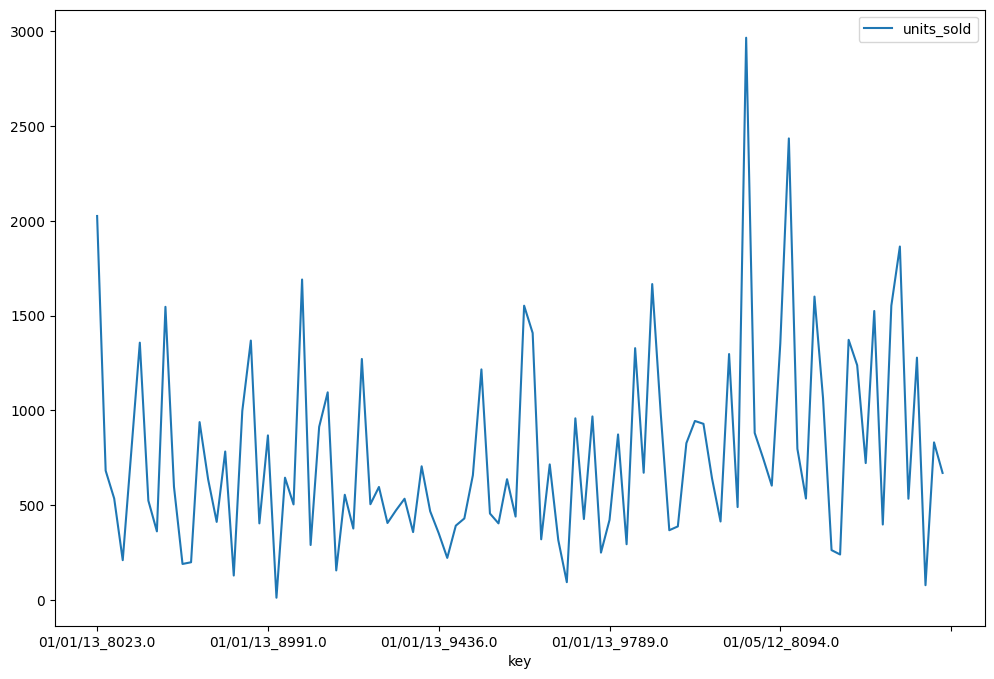

In [89]:
prep.df[:100].plot(figsize=(12,8))

## Converting supervised dataset

```units_sold``` becomes target variable

day_1, day_2, day_3, day_4, day_5 becomes input

We will train our model to predict sales based on previous 5 days.

In [90]:
prep.df['day_1'] = prep.df['units_sold'].shift(-1)
prep.df['day_2'] = prep.df['units_sold'].shift(-2)
prep.df['day_3'] = prep.df['units_sold'].shift(-3)
prep.df['day_4'] = prep.df['units_sold'].shift(-4)
prep.df['day_5'] = prep.df['units_sold'].shift(-5)

In [91]:
prep.df

,units_sold,day_1,day_2,day_3,day_4,day_5
key,,,,,,
01/01/13_8023.0,2025.0,682.0,535.0,210.0,782.0,1357.0
01/01/13_8058.0,682.0,535.0,210.0,782.0,1357.0,524.0
01/01/13_8063.0,535.0,210.0,782.0,1357.0,524.0,362.0
01/01/13_8091.0,210.0,782.0,1357.0,524.0,362.0,1546.0
01/01/13_8094.0,782.0,1357.0,524.0,362.0,1546.0,597.0
...,...,...,...,...,...,...
31/10/11_9890.0,531.0,551.0,431.0,820.0,506.0,NaN
31/10/11_9909.0,551.0,431.0,820.0,506.0,NaN,NaN
31/10/11_9954.0,431.0,820.0,506.0,NaN,NaN,NaN


Remove NA data

In [92]:
df = prep.df.dropna()

In [93]:
df

,units_sold,day_1,day_2,day_3,day_4,day_5
key,,,,,,
01/01/13_8023.0,2025.0,682.0,535.0,210.0,782.0,1357.0
01/01/13_8058.0,682.0,535.0,210.0,782.0,1357.0,524.0
01/01/13_8063.0,535.0,210.0,782.0,1357.0,524.0,362.0
01/01/13_8091.0,210.0,782.0,1357.0,524.0,362.0,1546.0
01/01/13_8094.0,782.0,1357.0,524.0,362.0,1546.0,597.0
...,...,...,...,...,...,...
31/10/11_9872.0,916.0,363.0,292.0,698.0,908.0,531.0
31/10/11_9876.0,363.0,292.0,698.0,908.0,531.0,551.0
31/10/11_9879.0,292.0,698.0,908.0,531.0,551.0,431.0


<Axes: xlabel='key'>

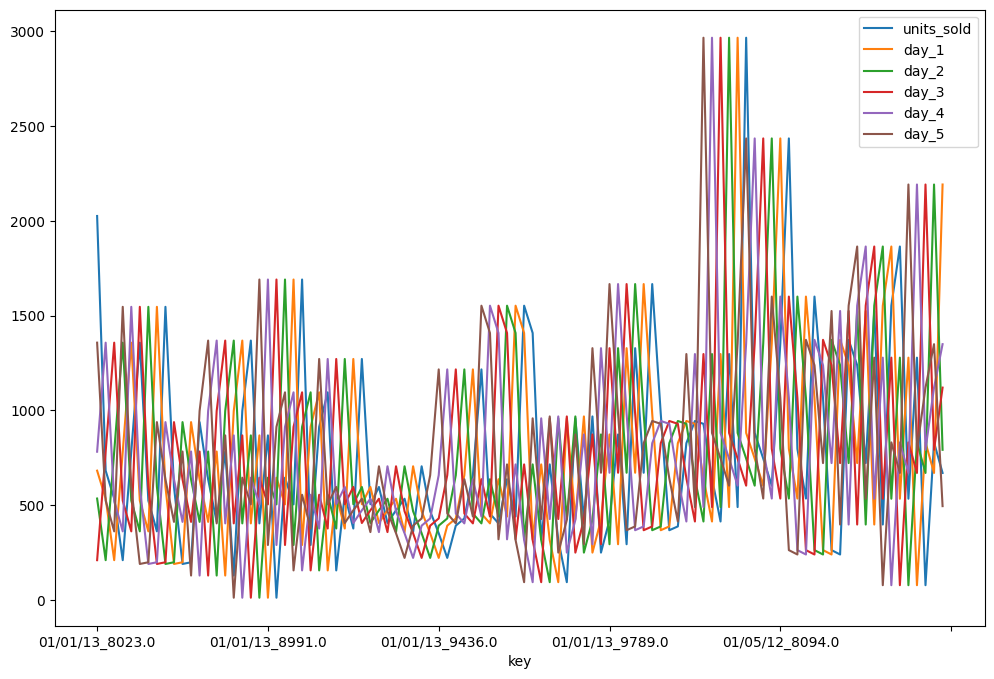

In [94]:
df[:100].plot(figsize=(12,8))

### Train-Test Split

In [95]:
x1, x2, x3, x4, x5, y = df['day_1'], df['day_2'], df['day_3'], df['day_4'], df['day_5'], df['units_sold']
x1, x2, x3, x4, x5, y = np.array(x1), np.array(x2), np.array(x3), np.array(x4), np.array(x5), np.array(y)
x1, x2, x3, x4, x5, y = x1.reshape(-1,1), x2.reshape(-1,1), x3.reshape(-1,1), x4.reshape(-1,1), x5.reshape(-1,1), y.reshape(-1,1)

split_percentage = 15
test_split = int(len(df)*(split_percentage/100))
x = np.concatenate((x1, x2, x3, x4, x5), axis=1)
X_train,X_test,y_train,y_test = x[:-test_split],x[-test_split:],y[:-test_split],y[-test_split:]

In [106]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(8394, 5) (1481, 5)
(8394, 1) (1481, 1)


## Tunning with Hyperopt

With auto preprocessing, as i have done preprocessing i will proceed without preprocessing.

    estimreg = HyperoptEstimator(regressor=any_regressor('reg'),
                            preprocessing=any_preprocessing("pre"),
                            algo=tpe.suggest,
                            max_evals=50,
                            trial_timeout=30)
                            

In [146]:
# HyperOpt
estimreg = HyperoptEstimator(regressor=any_regressor('reg'), algo=tpe.suggest, trial_timeout=50, n_jobs=4)

In [147]:
estimreg.fit(X_train, y_train)

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 50%|█████     | 1/2 [00:00<?, ?trial/s, best loss=?]

/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 75%|███████▌  | 3/4 [00:00<?, ?trial/s, best loss=?]

/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 80%|████████  | 4/5 [00:00<?, ?trial/s, best loss=?]

/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 83%|████████▎ | 5/6 [00:00<?, ?trial/s, best loss=?]

/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 86%|████████▌ | 6/7 [00:00<?, ?trial/s, best loss=?]

/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(



100%|██████████| 10/10 [00:50<00:00, 50.23s/trial, best loss: 0.2049713564998159]


In [108]:
test_acc = estimreg.score(X_test, y_test)

In [109]:
print("Testing accuracy: ", test_acc)

Testing accuracy:  0.7237618974520723


In [110]:
print(estimreg.best_model())

{'learner': RandomForestRegressor(criterion='absolute_error',
                      max_features=0.8286865212382253,
                      min_impurity_decrease=0.05, min_samples_leaf=19,
                      n_estimators=37, n_jobs=4, random_state=np.int64(1),
                      verbose=False), 'preprocs': (PCA(n_components=5),), 'ex_preprocs': ()}


## KNeighborsRegressor Model

In [168]:
knn_regressor = KNeighborsRegressor(n_neighbors=8, 
                                    algorithm='brute', leaf_size=33, metric='manhattan',
                                    n_jobs=1, p=3.091064814022803,
                                    weights='distance')

In [170]:
knn_regressor.fit(X_train, y_train)

KNeighborsRegressor(algorithm='brute', leaf_size=33, metric='manhattan',
                    n_jobs=1, n_neighbors=8, p=3.091064814022803,
                    weights='distance')

In [171]:
# Predict on test set
pred_Y = knn_regressor.predict(X_test)

In [174]:
# Evaluate the model
mse = mean_squared_error(y_test, pred_Y)
r2 = r2_score(y_test, pred_Y)
print(f"R-Square Score: {r2}")

R-Square Score: 0.8687336772157108


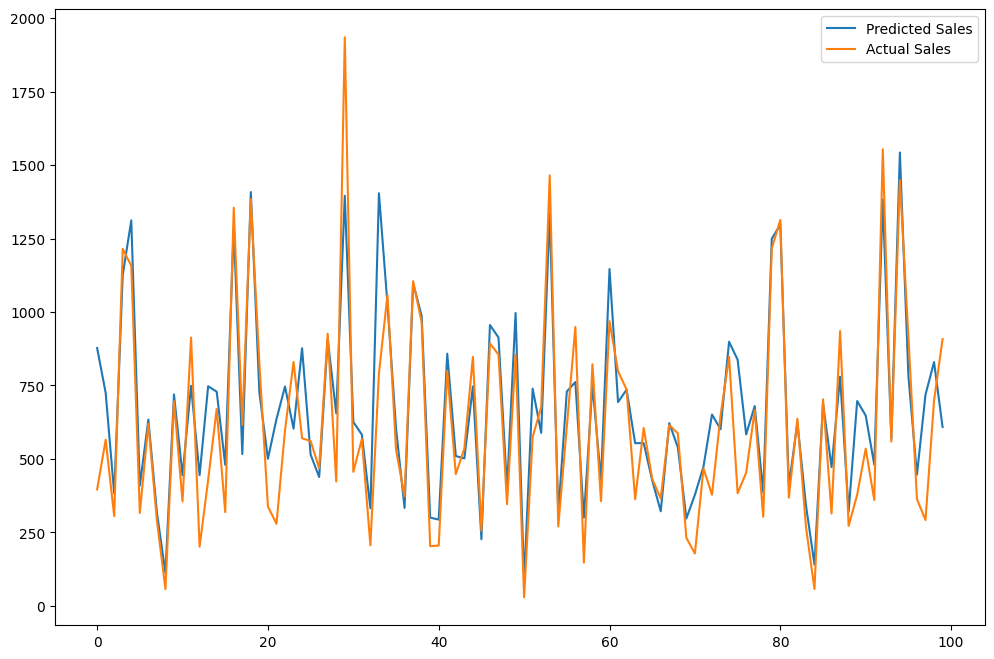

In [175]:
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(y_pred[-100:], label='Predicted Sales')
plt.plot(y_test[-100:], label='Actual Sales')
plt.legend(loc="upper right")
plt.savefig('KNRegressor.png')
plt.show()

## Custom RandomForestRegressor Model

In [139]:
regressor = RandomForestRegressor(n_jobs=10, bootstrap=True, verbose=1)
regressor.fit(X_train, y_train)

/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    2.2s finished


RandomForestRegressor(n_jobs=10, verbose=1)

In [140]:
y_pred = regressor.predict(X_test)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished


In [142]:
print("R-Square Score for RandomForestRegressor :", regressor.score(X_test, y_test))

R-Square Score for RandomForestRegressor : 0.8265641873655758


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished


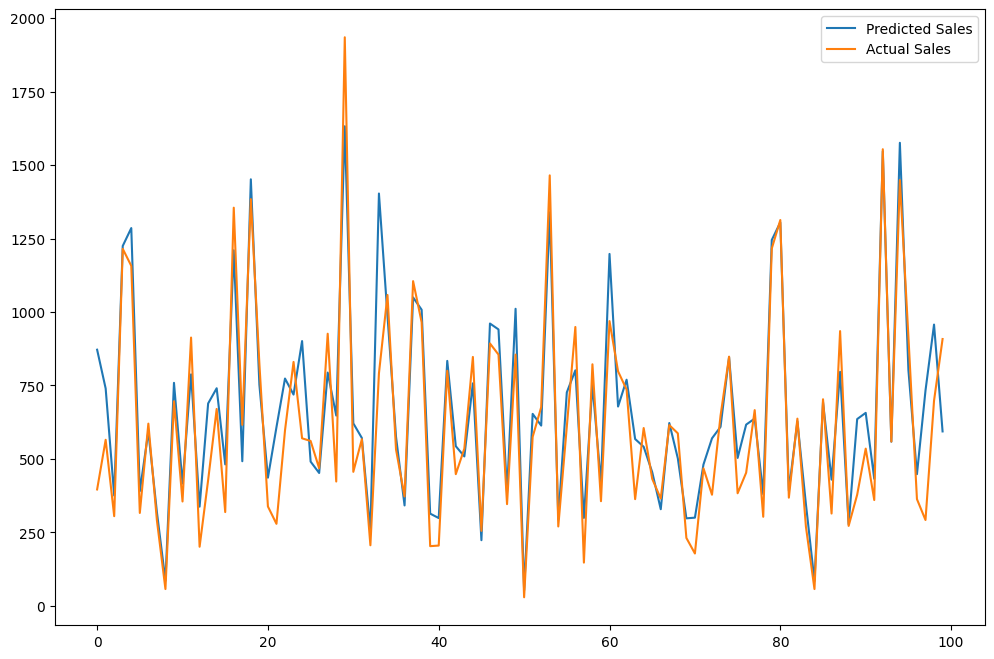

In [143]:
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(y_pred[-100:], label='Predicted Sales')
plt.plot(y_test[-100:], label='Actual Sales')
plt.legend(loc="upper right")
plt.savefig('default_RFR.png')
plt.show()

## XGBoost Regression

Trying XGBoost as well since its boosting mechanism often outperforms Random Forest on structured data, handling complexity more efficiently.

In [148]:
import xgboost

In [149]:
xgb_regressor = xgboost.XGBRegressor()
xgb_regressor.fit(X_train, y_train)

y_pred = xgb_regressor.predict(X_test)

In [150]:
print("R-Square Score for XGBoost Model :", xgb_regressor.score(X_test, y_test))

R-Square Score for XGBoost Model : 0.7657144170691306


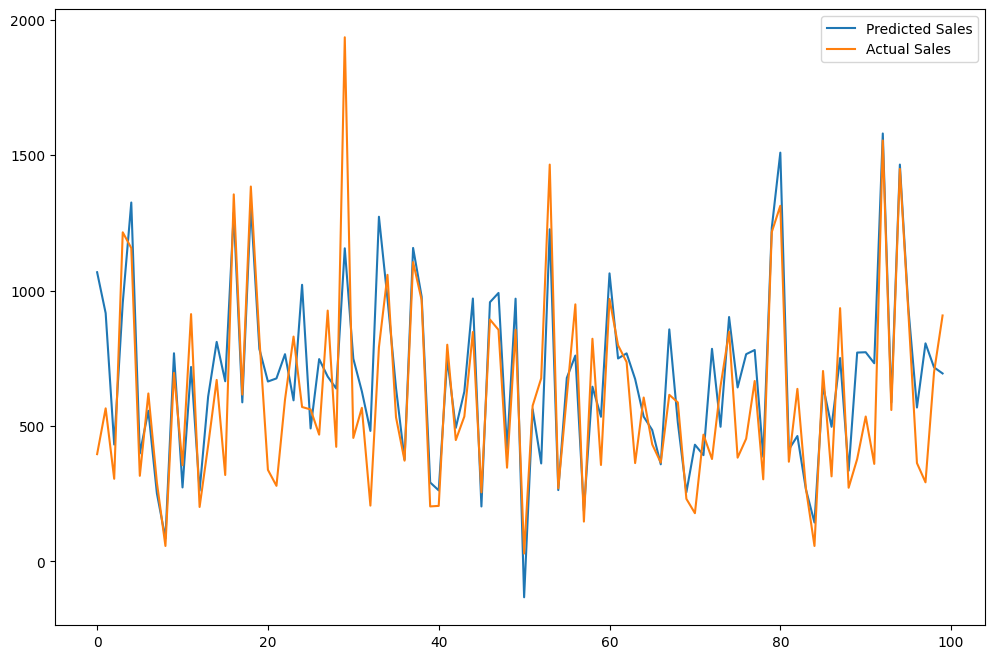

In [151]:
plt.plot(y_pred[-100:], label='Predicted Sales')
plt.plot(y_test[-100:], label='Actual Sales')
plt.legend(loc="upper right")
plt.savefig('xgBoost.png')
plt.show()

## Custom Hyperparameter Tuning for Random Forest

Following code demonstrates a **custom grid search approach** using `RandomizedSearchCV` to efficiently explore different hyperparameter combinations for a **Random Forest Regressor**. 

#### 1️ Defining the Hyperparameter Search Space  
I define a range of values for key hyperparameters:

- `n_estimators`: Number of trees in the forest (between 50 and 250).  
- `max_features`: Number of features considered for each split (`'log2'` or `'sqrt'`).  
- `max_depth`: Maximum depth of each tree (ranging from 0 to 120, plus `None` for unlimited depth).  
- `min_samples_split`: Minimum number of samples required to split an internal node (`2, 5, 10`).  
- `min_samples_leaf`: Minimum samples required at each leaf node (`1, 2, 4`).  
- `bootstrap`: Whether to use bootstrapped samples (`True` or `False`).  

All these hyperparameters are combined into a **random search grid**.

#### 2️ Performing Randomized Search with Cross-Validation  
I use `RandomizedSearchCV` to efficiently sample 10 different hyperparameter combinations (instead of testing all possible ones) with **3-fold cross-validation**:

- **Base model**: `RandomForestRegressor()`
- **Search strategy**: `RandomizedSearchCV`
- **Evaluations**: 10 random configurations (`n_iter = 10`)
- **Cross-validation folds**: 3 (`cv = 3`)
- **Parallel execution**: All available cores (`n_jobs = -1`)
- **Verbose logging**: Level 2 (`verbose = 2`)

#### 3️ Fitting the Model  
The **randomized search** is executed on the dataset (`X_train`, `y_train`) to find the best-performing hyperparameter combination.

#### Why Randomized Search?  
- More efficient than **Grid Search** (which tests all possible combinations).  
- Allows finding **good hyperparameters faster**, especially for large datasets.  
- Helps avoid overfitting by testing different configurations.  



In [152]:
# Defining # of trees
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 250, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum # levels in tree
max_depth = [int(x) for x in np.linspace(0, 120, num = 20)]
max_depth.append(None)
# Minimum # samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum # samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap
            }
print(random_grid)

{'n_estimators': [50, 72, 94, 116, 138, 161, 183, 205, 227, 250], 'max_features': ['log2', 'sqrt'], 'max_depth': [0, 6, 12, 18, 25, 31, 37, 44, 50, 56, 63, 69, 75, 82, 88, 94, 101, 107, 113, 120, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [153]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                                n_iter = 10, cv = 3, verbose=2, random_state=0, n_jobs = -1
                            )

In [155]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/base.py:1389:

[CV] END bootstrap=True, max_depth=94, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=94; total time=   3.5s


/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=94, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=94; total time=   3.8s
[CV] END bootstrap=True, max_depth=94, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=94; total time=   3.9s


/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=88, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=205; total time=   5.5s


/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=56, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=116; total time=   3.2s


/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=88, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=205; total time=   4.8s


/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=88, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=205; total time=   4.8s


/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=56, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=116; total time=   3.2s


/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=56, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=116; total time=   3.2s


/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=113, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=138; total time=   3.9s


/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=113, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=138; total time=   3.4s


/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=72; total time=   2.1s
[CV] END bootstrap=True, max_depth=113, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=138; total time=   3.3s


/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=72; total time=   2.5s
[CV] END bootstrap=False, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=72; total time=   2.3s


/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=31, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=250; total time=   7.6s


/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=31, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=250; total time=   7.9s


/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=69, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=205; total time=   7.5s


/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=31, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=250; total time=   8.2s


/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=69, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=205; total time=   6.5s


/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=69, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=205; total time=   6.8s


/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=205; total time=   7.0s


/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=205; total time=   7.0s


/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=31, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=116; total time=   3.4s


/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=31, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=116; total time=   3.0s


/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=31, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=116; total time=   3.0s


/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=205; total time=   7.5s
[CV] END bootstrap=False, max_depth=18, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=116; total time=   3.8s
[CV] END bootstrap=False, max_depth=18, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=116; total time=   3.2s
[CV] END bootstrap=False, max_depth=18, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=116; total time=   3.0s


/home/zawster/Documents/MyWork/DS_Projects/env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [0, 6, 12, 18, 25, 31, 37,
                                                      44, 50, 56, 63, 69, 75,
                                                      82, 88, 94, 101, 107, 113,
                                                      120, None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 72, 94, 116, 138,
                                                         161, 183, 205, 227,
                                                         250]},
                   random_state=0, verbose=2)

In [156]:
rf_random.best_params_

{'n_estimators': 205,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [121]:
best_random = rf_random.best_estimator_

In [157]:
y_pred = best_random.predict(X_test)

In [159]:
print("R-Square Score for RandomForestRegressor :", best_random.score(X_test, y_test))
print("Adj. R-Square Score for RandomForestRegressor :", 1 - (1 - best_random.score(X_test, y_test) ) * ( len(y_test) - 1 ) / ( len(y_test) - X_test.shape[1] - 1 ))

R-Square Score for RandomForestRegressor : 0.829878988999185
Adj. R-Square Score for RandomForestRegressor : 0.8293023076059619


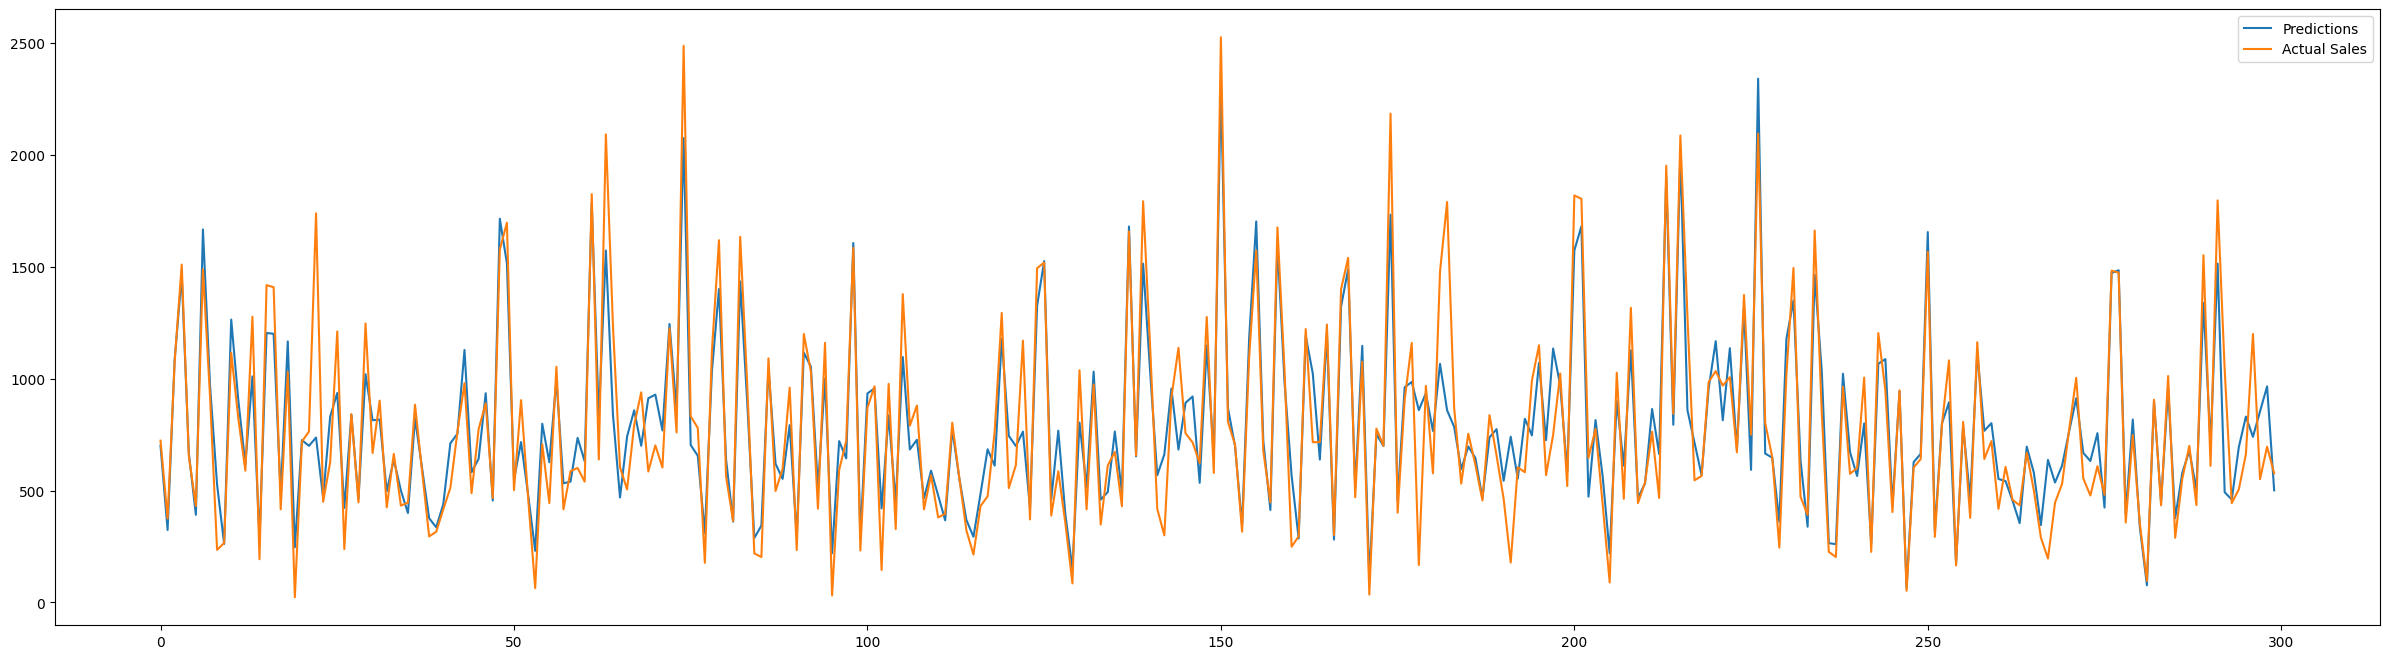

In [160]:
plt.rcParams["figure.figsize"] = (30,8)
plt.plot(y_pred[500:800], label='Predictions')
plt.plot(y_test[500:800], label='Actual Sales')
plt.legend(loc="upper right")
plt.savefig('custom_tunnedRFR.png')
plt.show()

In [162]:
df.to_csv("data/processed_train_data.csv", header=True)